In [11]:
import pickle

import numpy as np
import pandas as pd
import scipy.sparse
import scipy.sparse
import seaborn as sns
from sklearn.decomposition import PCA

from lightfm import LightFM

In [12]:
df = pd.read_parquet('/pio/scratch/1/recommender_systems/processed/amazon-clothes/5-core/train.parquet')
test_df = pd.read_parquet('/pio/scratch/1/recommender_systems/processed/amazon-clothes/5-core/test.parquet')
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [13]:
interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_interactions.npz')
test_interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_test_interactions.npz')
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/5_core_dataset.pkl')

In [14]:
items = df['asin'].drop_duplicates()
item_mapping = dataset.mapping()[2]
items_categories = categories[categories.asin.isin(items)].drop_duplicates()
num_categories = len(categories.category_1.unique())

In [15]:
# https://math.stackexchange.com/questions/117164/calculate-coordinates-of-a-regular-polygon?rq=1
all_embeddings = pd.DataFrame()
for i, (group, data) in enumerate(items_categories.groupby(['category_1'])):
    embeddings = pd.DataFrame(np.hstack([
        np.random.normal(2*np.sin(i*360/num_categories), 0.5, (len(data), 50)),
        np.random.normal(2*np.cos(i*360/num_categories), 0.5, (len(data), 50))]
    ))
    embeddings.index = data['asin']
    all_embeddings = pd.concat([all_embeddings, embeddings])

In [16]:
without_category = set(items) - set(all_embeddings.index)
embeddings = pd.DataFrame(np.random.normal(0.0, 0.5, (len(without_category), 100)))
embeddings.index = list(without_category)
all_embeddings = pd.concat([all_embeddings, embeddings])

<AxesSubplot:xlabel='0', ylabel='1'>

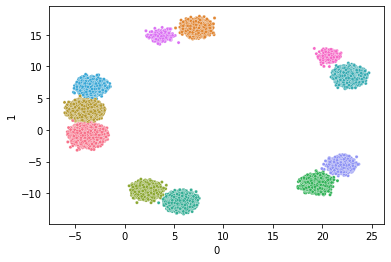

<AxesSubplot:xlabel='0', ylabel='1'>

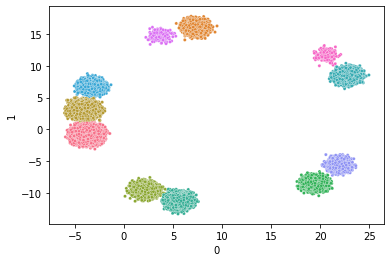

In [17]:
pca = PCA(n_components=2)
reduced_embeddings = pd.DataFrame(pca.fit_transform(all_embeddings))
reduced_embeddings.index = all_embeddings.index

reduced_embeddings = reduced_embeddings.join(categories.set_index('asin'))
reduced_embeddings.columns = ['0', '1', 'category_1', 'category_2']

sns.scatterplot(x='0', y='1', data=reduced_embeddings, hue='category_1', s=10, legend=False)

In [18]:
item_mapping = dataset.mapping()[2]
all_embeddings = all_embeddings.rename(index=item_mapping)
all_embeddings = all_embeddings.sort_index()

In [19]:
model = LightFM(no_components=100, learning_schedule='adadelta', loss='warp')

my new implementation
my new implementation


In [10]:
num_epochs = [5, 25, 50, 250, 500, 1000]
remaining = [num_epochs[0]] + [num_epochs[i] - num_epochs[i-1] for i in range(1, len(num_epochs))]
for i, epochs in enumerate(num_epochs):
    model.fit_partial(interactions, verbose=True, epochs=remaining[i], num_threads=8, word2vec_embeddings=all_embeddings.values)
    pickle.dump(model, open(f'/pio/scratch/1/i313924/data/lightfm_data/model_{epochs}_epochs_separated_initialization.pkl', 'wb'), protocol=4)

Epoch:  12%|█▏        | 3/25 [00:16<01:55,  5.24s/it]